In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pickle
import os
import numpy as np
import cv2
%matplotlib inline

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/datasets/chest_xray/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = os.path.join(path, 'train','undersampled')
val = os.path.join(path, 'val')
test = os.path.join(path, 'test')

In [ ]:
print(
    train+'\n',
    test+'\n',
    val
)

/content/drive/MyDrive/datasets/chest_xray/train/undersampled
 /content/drive/MyDrive/datasets/chest_xray/test
 /content/drive/MyDrive/datasets/chest_xray/val


In [ ]:
def count_file(dir=None, labels=None):
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'jumlah {label} : {num_data}')

labels= ['PNEUMONIA','NORMAL']
print('Train Set: \n' + '='*50)
count_file(train,labels)

print('\nValidation Set: \n' + '='*50)
count_file(val,labels)

print('\nTest Set: \n' + '='*50)
count_file(test,labels)

Train Set: 
jumlah PNEUMONIA : 1341
jumlah NORMAL : 1341

Validation Set: 
jumlah PNEUMONIA : 8
jumlah NORMAL : 8

Test Set: 
jumlah PNEUMONIA : 390
jumlah NORMAL : 234


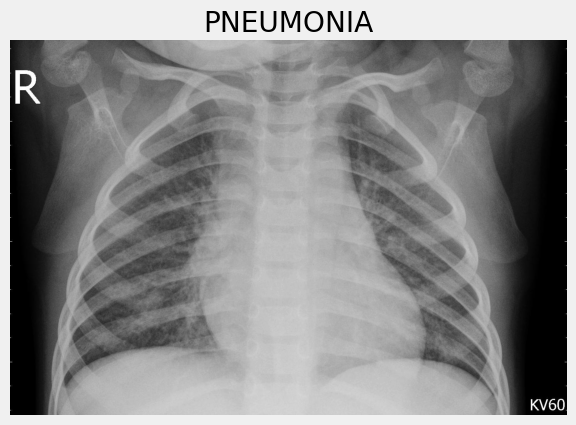

In [ ]:
# Assuming 'train' is a tuple containing image path and label index
image_path = os.path.join(train, 'PNEUMONIA', os.listdir(os.path.join(train, 'PNEUMONIA'))[0])
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('PNEUMONIA')  # You can replace this with the actual label
plt.show()


In [ ]:
X = []
y = []

# Function to load and resize images from a directory
def load_and_resize_images(directory, label, target_size):
    for filename in os.listdir(directory):
        if filename.endswith(".jpeg"):
            path = os.path.join(directory, filename)
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            # Resize the image to the target size
            image = cv2.resize(image, (target_size, target_size))
            X.append(image)
            y.append(label)

# Specify the target size for resizing
target_size = 200  # Adjust this size based on your requirements

# Load and resize images from the 'PNEUMONIA' and 'NORMAL' directories in the 'train' set
load_and_resize_images(os.path.join(train, 'PNEUMONIA'), 1, target_size)
load_and_resize_images(os.path.join(train, 'NORMAL'), 0, target_size)

# Load and resize images from the 'PNEUMONIA' and 'NORMAL' directories in the 'test' set
load_and_resize_images(os.path.join(test, 'PNEUMONIA'), 1, target_size)
load_and_resize_images(os.path.join(test, 'NORMAL'), 0, target_size)

# Load and resize images from the 'PNEUMONIA' and 'NORMAL' directories in the 'val' set
load_and_resize_images(os.path.join(val, 'PNEUMONIA'), 1, target_size)
load_and_resize_images(os.path.join(val, 'NORMAL'), 0, target_size)

# Convert lists to NumPy arrays
X = np.array(X).reshape(-1, target_size, target_size, 1)
y = np.array(y)

# Split the dataset into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)


In [ ]:
# Normalize pixel values to be in the range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0


In [ ]:
# good for balancing out disproportions in the dataset
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True)

datagen.fit(X_train)

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 200, 200, 256)     2560      
                                                                 
 activation_5 (Activation)   (None, 200, 200, 256)     0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 100, 100, 256)     0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 100, 100, 256)     400       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 64)      147520    
                                                                 
 activation_6 (Activation)   (None, 100, 100, 64)     

In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=10),
    callbacks=[early_stop], validation_data=(X_val, y_val),
    epochs=15
    )

Epoch 1/15
213/213 [==============================] - 1365s 6s/step - loss: 0.7485 - acc: 0.5591 - val_loss: 1.1390 - val_acc: 0.5338
Epoch 2/15
213/213 [==============================] - 1357s 6s/step - loss: 0.5771 - acc: 0.6908 - val_loss: 2.6670 - val_acc: 0.5338
Epoch 3/15
213/213 [==============================] - 1332s 6s/step - loss: 0.4758 - acc: 0.7675 - val_loss: 0.6946 - val_acc: 0.6335
Epoch 4/15
213/213 [==============================] - 1329s 6s/step - loss: 0.4368 - acc: 0.8033 - val_loss: 0.3644 - val_acc: 0.8252
Epoch 5/15
213/213 [==============================] - 1334s 6s/step - loss: 0.3863 - acc: 0.8278 - val_loss: 0.2864 - val_acc: 0.8910
Epoch 6/15
213/213 [==============================] - 1330s 6s/step - loss: 0.3683 - acc: 0.8433 - val_loss: 0.7748 - val_acc: 0.6504
Epoch 7/15
213/213 [==============================] - 1355s 6s/step - loss: 0.3375 - acc: 0.8555 - val_loss: 0.2847 - val_acc: 0.8741
Epoch 8/15
213/213 [==============================] - 1331s 6s

In [ ]:
model.evaluate(X_test, y_test)

21/21 [==============================] - 106s 5s/step - loss: 0.2898 - acc: 0.8707


[0.2898162007331848, 0.8706766963005066]

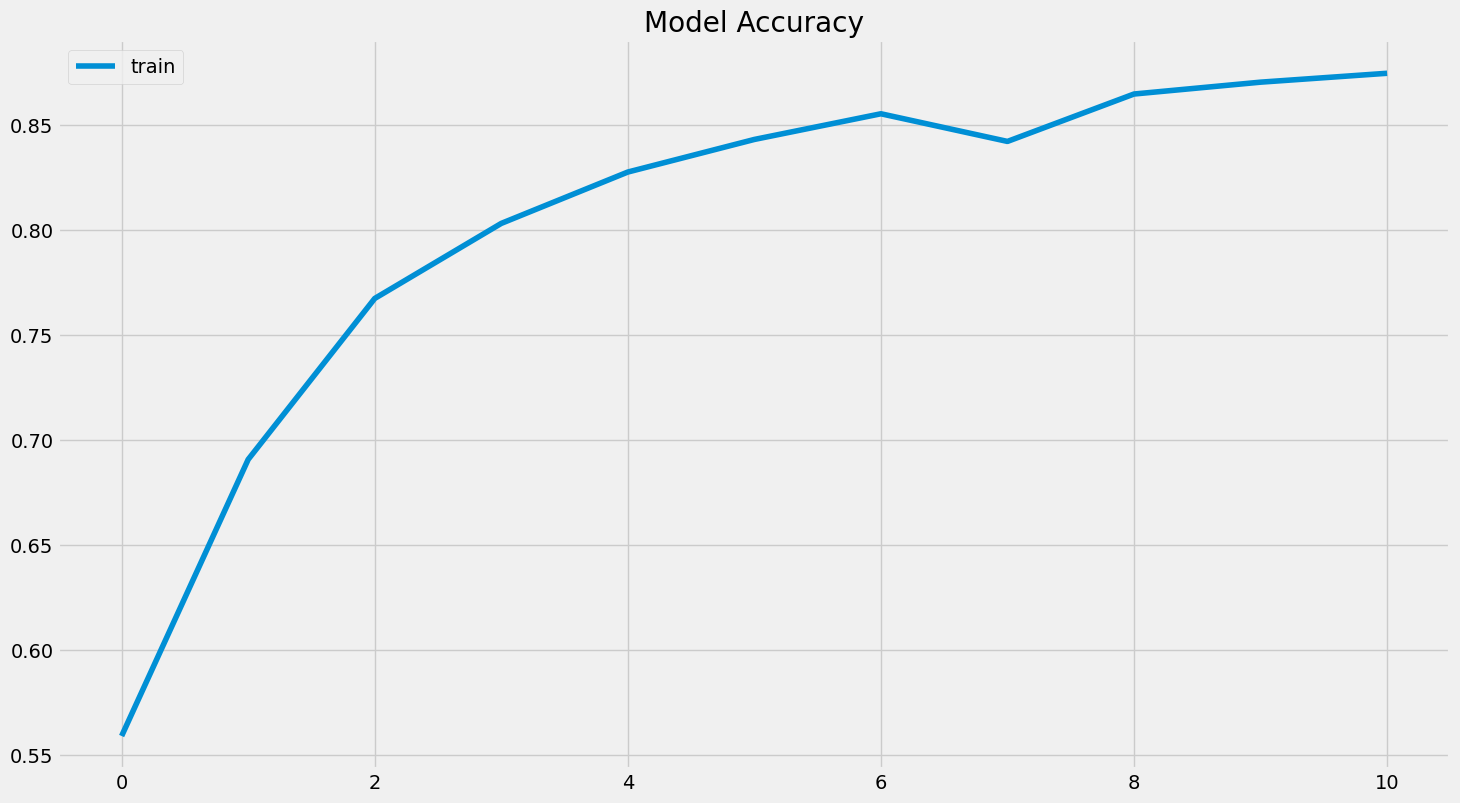

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()



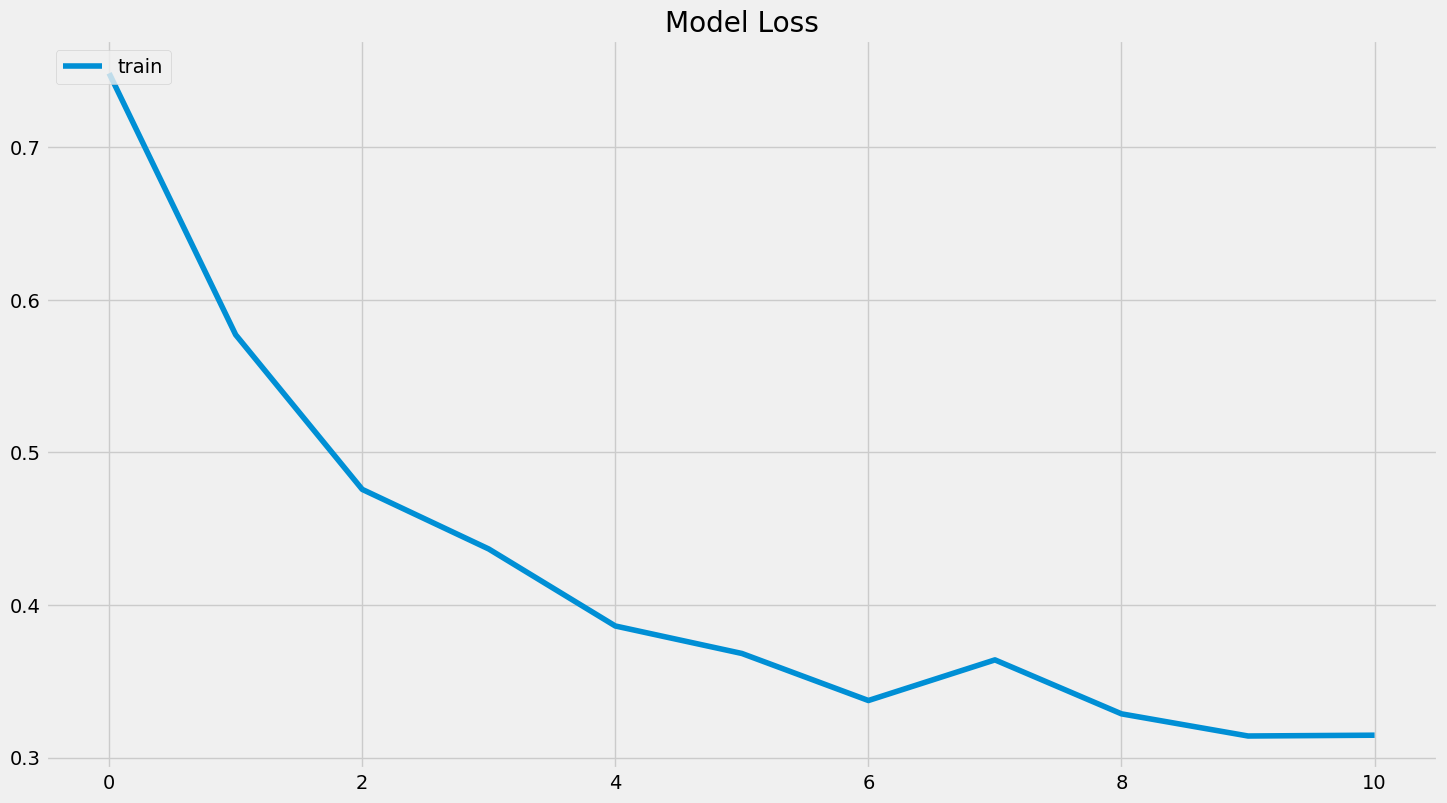

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()



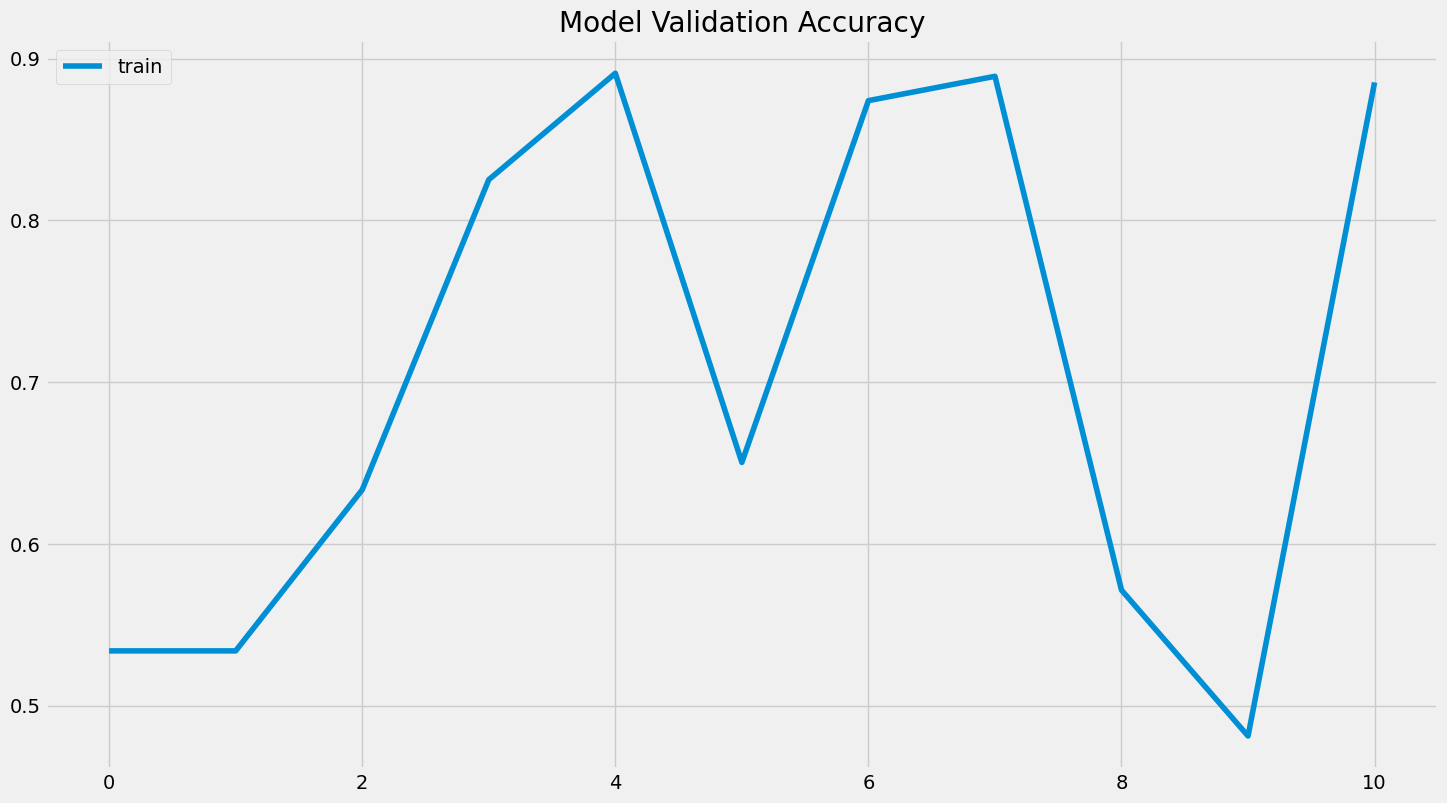

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()



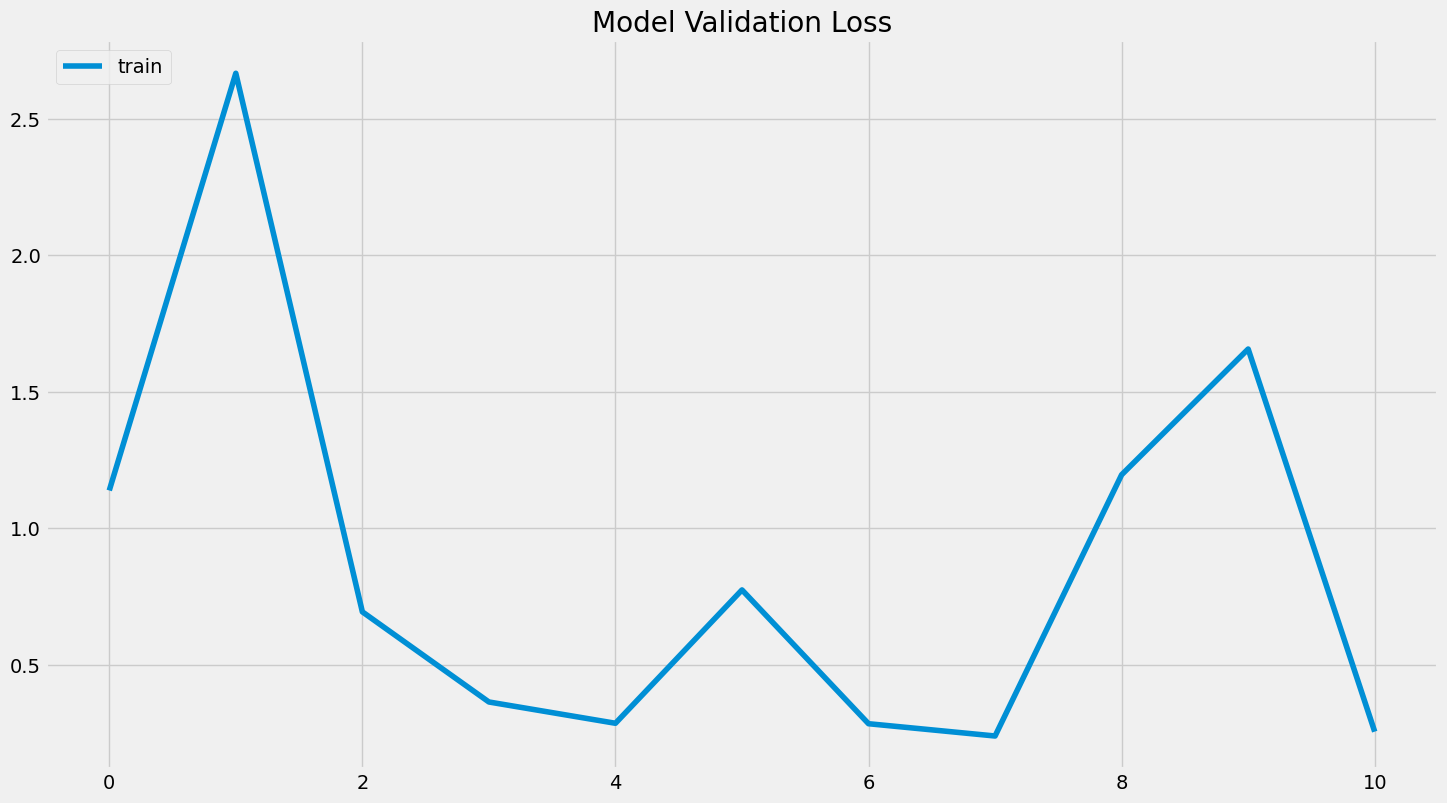

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

67/67 [==============================] - 352s 5s/step


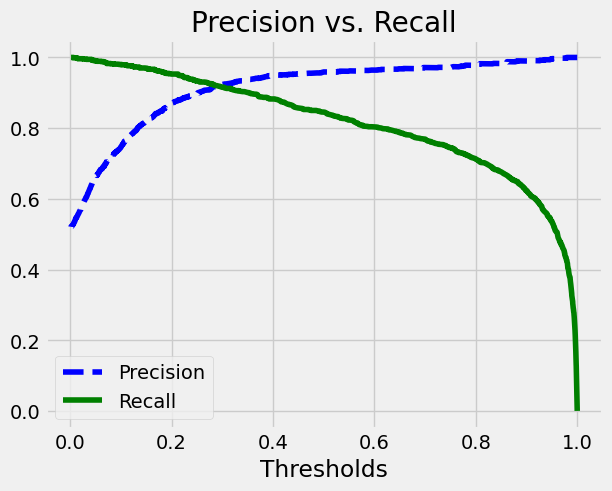

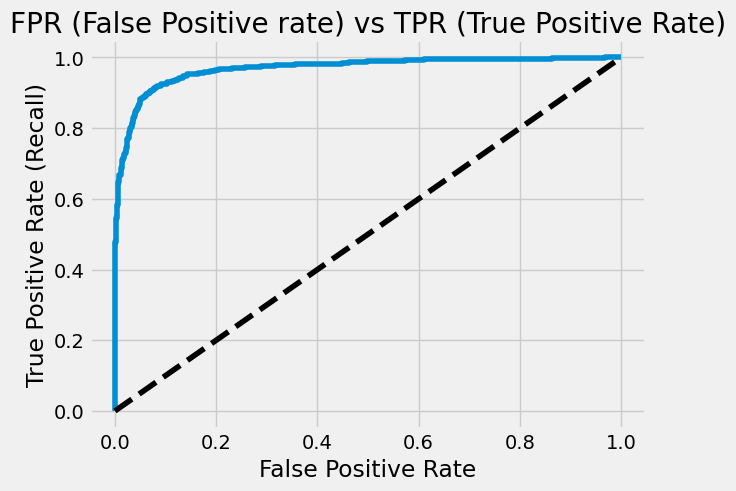

In [ ]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()

plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [ ]:
predictions = model.predict(X_test)

21/21 [==============================] - 107s 5s/step


In [ ]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.8526315789473684
Precision on testing set: 0.968299711815562
Recall on testing set: 0.7943262411347518


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

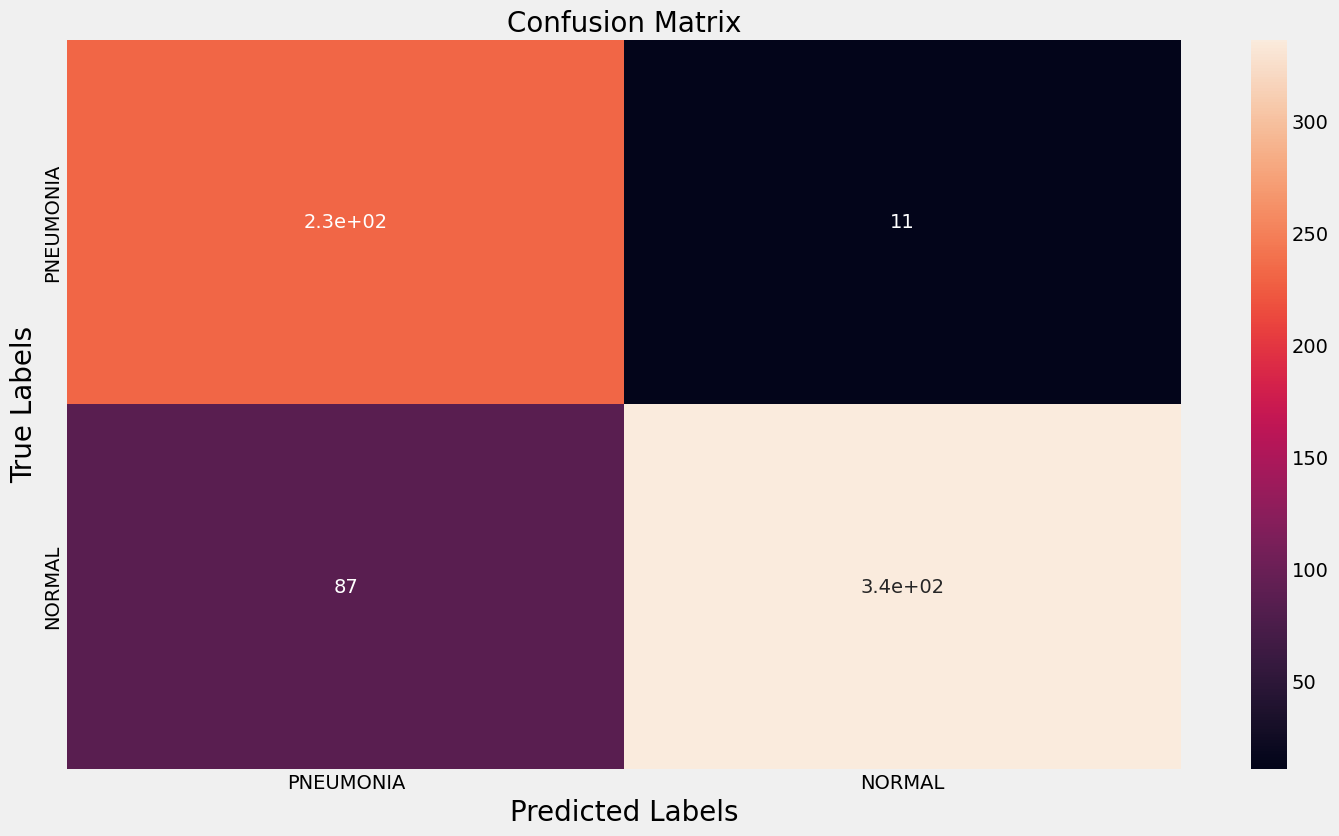

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

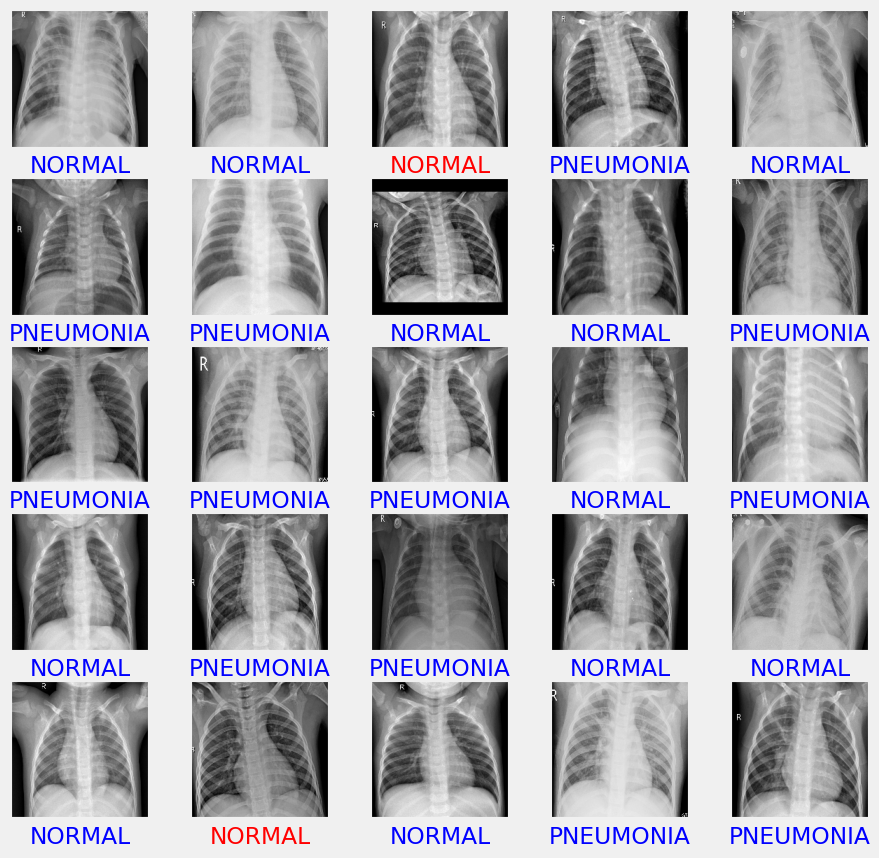

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

In [ ]:
from tensorflow.keras.models import save_model

# Assuming 'model' is the variable representing your trained model
model_path = '/content/your_model.h5'
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import cv2
import requests
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/content/your_model.h5')  # Adjust the path accordingly

# Define a function to preprocess the image from the URL
def preprocess_image_from_url(url, target_size=(200, 200)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.convert('L')  # Convert to grayscale
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, *target_size, 1)
    return img_array

# Provide the image URL to predict
image_url = "https://d2jx2rerrg6sh3.cloudfront.net/image-handler/picture/2020/6/shutterstock_786937069.jpg"  # Replace with your image URL
preprocessed_image = preprocess_image_from_url(image_url)

# Make predictions using the loaded model
prediction = loaded_model.predict(preprocessed_image)
predicted_class = (prediction > 0.5).astype(int)[0][0]

# Map class indices to actual class labels
class_labels = {0: 'NORMAL', 1: 'PNEUMONIA'}
predicted_label = class_labels[predicted_class]

print(f"The predicted class is: {predicted_label}")


1/1 [==============================] - 1s 690ms/step
The predicted class is: PNEUMONIA
